# Essential dynamics

In [1]:
import torch
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import sys

import numpy as np
import tqdm
import seaborn as sns
import os
import colorsys
import pickle

from typing import Dict, Iterable
from sklearn.decomposition import PCA
from collections import defaultdict

sns.set_style("white")

plt.rcParams["figure.dpi"] = 300

In [2]:
MODEL_SEED = 1
steps = range(0, 500_000, 10)[::10]
DEVICE = (
    "mps"
    if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)

sys.path.insert(0, 'home/paperspace/icl')

models = torch.load(f"../models.pt", map_location=DEVICE)
# TODO non context bound save / load
models = models[MODEL_SEED]

In [3]:
TRANSITIONS = [
    (0, 1500, "R1"),
    (1500, 40_000, "R2"),
    # (7_500, 40000, 'R3'),
    (40000, 320000, "R3"),
    # (120000, 320000, 'R5'),
    (320000, 500000, "R4"),
]


def gen_transition_colors(types):
    """Generates a palette for transition colors. Orange-flavored for Type A. Blue-flavored for Type B."""
    num_type_a = sum([t == "A" for t in types])
    num_type_b = sum([t == "B" for t in types])
    num_other = sum([t == "Other" for t in types])

    type_a_palette = sns.color_palette("Oranges_r", num_type_a)
    type_b_palette = sns.color_palette("Blues_r", num_type_b)
    other_palette = sns.color_palette("Greys_r", num_other)

    palette = []

    for t in types:
        if t == "A":
            palette.append(type_a_palette.pop())
        elif t == "B":
            palette.append(type_b_palette.pop())
        else:
            palette.append(other_palette.pop())

    return palette


def get_transition_type(transition):
    if len(transition) == 4:
        return transition[-1]

    if "A" in transition[-1]:
        return "A"

    if "B" in transition[-1]:
        return "B"

    return "Other"


def increase_saturation(rgb, saturation_factor):
    # Convert RGB to HSV
    hsv = colorsys.rgb_to_hsv(*rgb)

    # Increase saturation by the given factor, making sure it stays in [0, 1]
    new_s = min(max(hsv[1] * saturation_factor, 0), 1)

    # Convert back to RGB
    new_rgb = colorsys.hsv_to_rgb(hsv[0], new_s, hsv[2])
    return new_rgb


def increase_contrast(rgb, contrast_factor):
    # Midpoint
    midpoint = 128.0 / 255

    # Increase contrast
    new_rgb = [(0.5 + contrast_factor * (component - 0.5)) for component in rgb]

    # Clip to the range [0, 1]
    new_rgb = [min(max(component, 0), 1) for component in new_rgb]
    return new_rgb


transition_types = [get_transition_type(t) for t in TRANSITIONS]
transition_colors = gen_transition_colors(transition_types)

transition_colors = [increase_saturation(rgb, 2) for rgb in transition_colors]
transition_colors = [increase_contrast(rgb, 2) for rgb in transition_colors]

transitions_cmap = LinearSegmentedColormap.from_list("transitions", transition_colors)

In [4]:
def get_transition_indices(steps, transitions):
    transition_indices = []
    for step in steps:
        # Find the index of the transition that the current step falls into
        index = next(
            (
                i
                for i, transition in enumerate(transitions)
                if transition[0] <= step < transition[1]
            ),
            None,
        )
        transition_indices.append(index if index is not None else -1)

    return transition_indices


def get_nearest_step(step):
    idx = np.argmin(np.abs(np.array(steps) - step))
    return steps[idx]


def plot_explained_variance(pca, title="Explained Variance", ax: plt.Axes = None):
    num_pca_components = pca.n_components

    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))

    ax.bar(
        range(num_pca_components), pca.explained_variance_ratio_[:num_pca_components]
    )

    for i, ratio in enumerate(pca.explained_variance_ratio_[:num_pca_components]):
        ax.text(i, ratio, f"{ratio:.2f}", fontsize=12, ha="center", va="bottom")

    ax.set_title(title)
    ax.set_xlabel("PC")
    ax.set_ylabel("Explained Variance")

    ax.set_xticks(range(num_pca_components), range(1, num_pca_components + 1))


def plot_multiple_slices(
    steps,
    samples,
    pca,
    transitions,
    highlighted_steps=None,
    connect_dots=False,
    palette="tab10",
    alpha=0.8,
    save=False,
    line_color="auto",
):
    transition_idxs = get_transition_indices(steps, transitions)
    if highlighted_steps is None:
        highlighted_steps = list(map(get_nearest_step, [t[0] for t in transitions][1:]))

    num_pca_components = samples.shape[-1]

    num_pca_combos = (num_pca_components * (num_pca_components - 1)) // 2

    fig, axes = plt.subplots(1, num_pca_combos + 1, figsize=(20, 4))
    if num_pca_components == 2:
        axes = [axes]

    I = 0
    for i in range(1, num_pca_components):
        for j in range(i):

            if connect_dots:
                axes[I].plot(samples[:, i], samples[:, j], c="black", alpha=0.2)

            sns.scatterplot(
                x=samples[:, i],
                y=samples[:, j],
                hue=transition_idxs,
                palette=palette,
                s=50,
                alpha=alpha,
                ax=axes[I],
                legend=False,
            )
            axes[I].set_xlabel(f"PC {i}")
            axes[I].set_ylabel(f"PC {j}")
            axes[I].set_title(f"PC {i} vs PC {j}")

            for step in highlighted_steps:
                k = steps.index(step)  # Find the index of the highlighted step
                axes[I].text(
                    samples[k, i],
                    samples[k, j],
                    str(step),
                    fontsize=8,
                    ha="right",
                    va="bottom",
                    alpha=0.8,
                )

            I += 1

    plot_explained_variance(pca, ax=axes[-1], num_pca_components=num_pca_components)
    cmap = sns.palettes.color_palette(palette, n_colors=len(transitions) + 1)
    legend_ax = axes[0]
    scatter_proxy = [
        plt.Line2D([0], [0], linestyle="none", marker="o", alpha=alpha, color=cmap[i])
        for i in range(len(transitions))
    ]
    legend_labels = [label for _, _, label in transitions]
    legend_ax.legend(
        scatter_proxy,
        legend_labels,
        loc="center",
        ncol=1,
        frameon=False,
        bbox_to_anchor=(-0.5, 0.5),
        title="Developmental Stages",
    )
    plt.tight_layout(
        rect=[0, 0, 0.9, 1]
    )  # Adjust the right side to make room for the colorbar
    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

    fig.set_facecolor("white")

In [5]:
def get_output_for_model(model: nn.Module, dataloader: DataLoader):
    model.to(DEVICE)
    logits = []
    with torch.no_grad():
        for xs, ys in dataloader:
            xs, ys = xs.to(model.device), ys.to(model.device)
            outputs = model(xs, ys)
            logits.append(outputs)
    logits = torch.cat(logits).to('cpu')
    return logits


def get_output_for_models(models: Iterable[nn.Module], dataloader: DataLoader):
    outputs = torch.stack([get_output_for_model(model, dataloader) for model in models])
    return outputs.reshape(len(outputs), -1)


def get_pca_components(samples, n_components):
    pca = PCA(n_components=n_components)
    transformed_samples = pca.fit_transform(samples)
    return pca, transformed_samples

In [6]:
BATCH_SIZE = 1024
dataset = torch.load("ED_dataset.pt")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

outputs = get_output_for_models(models, dataloader)


In [14]:
def plot_essential_dynamics_grid(pca, transformed_samples, figsize=(20, 4)):
    num_pca_components = pca.n_components
    # Create a single row of subplots
    num_pca_combos = (num_pca_components * (num_pca_components - 1)) // 2
    fig, axes = plt.subplots(1, num_pca_combos + 1, figsize=figsize)

    # Ensure ax is iterable by converting to a list if there's only one subplot
    if num_pca_components == 2:
        axes = [axes]
    I = 0
    for i in range(1, num_pca_components):
        for j in range(i):
            sns.scatterplot(
                x=transformed_samples[:, i],
                y=transformed_samples[:, j],
                ax=axes[I],
                alpha=0.5,
                color="gray",
                s=10,
                legend=False,
            )

            axes[I].plot(transformed_samples[:, i], transformed_samples[:, j])

            axes[I].set_xlabel(f"PC {i+1}")
            axes[I].set_ylabel(f"PC {j+1}")
            axes[I].set_title(f"PC {j+1} vs PC {i+1}")

            I += 1
    plot_explained_variance(pca, ax=axes[-1])
    plt.tight_layout(rect=[0, 0, 1, 1])
    return fig

[(0, 900, 'A')]
[(0, 1500, 'R1'), (1200, 10000, 'B')]


<ipython-input-15-376164b86d16>:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


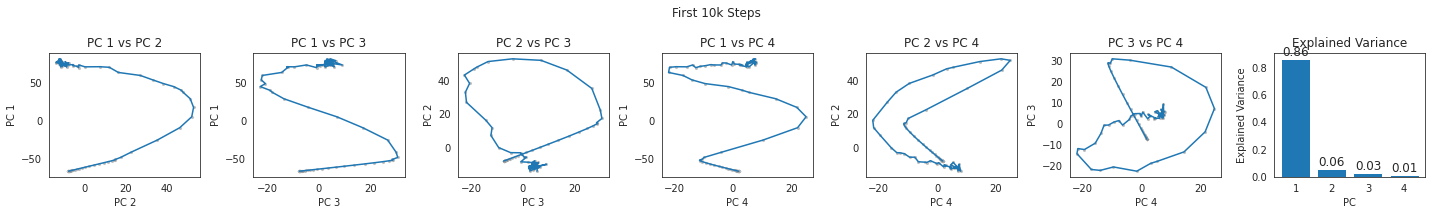

[(0, 1500, 'R1'), (1500, 40000, 'R2'), (40000, 320000, 'R3'), (60001, 100000, 'D')]


<ipython-input-15-376164b86d16>:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


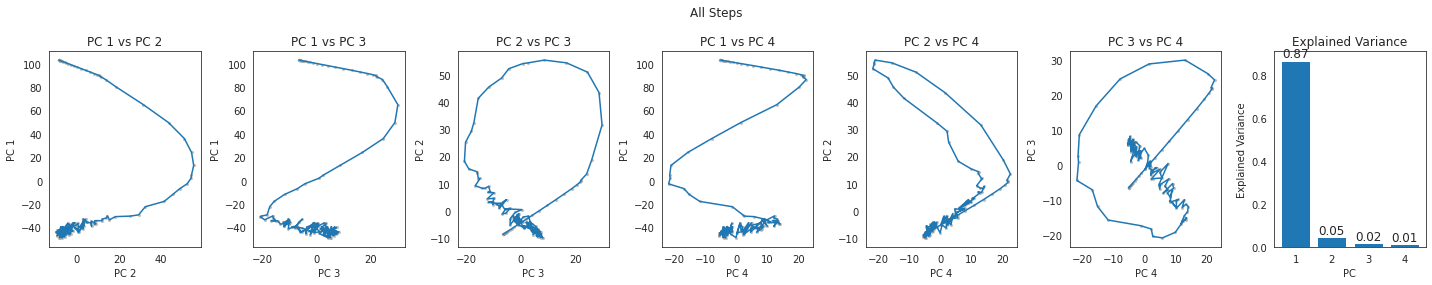

In [15]:
_all_outputs = outputs

pca, transformed_samples = get_pca_components(_all_outputs[:101], n_components=4)
fig = plot_essential_dynamics_grid(pca, transformed_samples, figsize=(20, 3))
fig.suptitle("First 10k Steps")
plt.tight_layout()
plt.show()

pca, transformed_samples = get_pca_components(_all_outputs, n_components=4)
fig = plot_essential_dynamics_grid(pca, transformed_samples, figsize=(20, 4))
fig.suptitle("All Steps")
plt.tight_layout()
plt.show()